In [4]:
import sys, os
import numpy as np
import xarray as xr
import pandas as pd

# matplotlib
import matplotlib.pyplot as plt
# plot styles/formatting
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import cartopy.feature as cfeature

# Path to modules
sys.path.append('../modules/')
import globalvars
from wrf_utils import load_preprocessed_WRF_data
from plotter import plot_trend_with_clim
from xarrayMannKendall import compute_MK_trend_da

model = 'cfsr'
path_to_data = globalvars.path_to_data
varnames = ['ivt', 'pcpt', 'freezing_level', 'uv925']

# # load data
ds = load_preprocessed_WRF_data(model, 'uv925', anomaly=False)

## compute 95th percentile for var for each year
ds = ds.groupby("time.year").quantile(0.95, dim="time").rename(year="time")
ds

<xarray.Dataset> Size: 77MB
Dimensions:   (time: 40, y: 250, x: 320)
Coordinates:
    lat       (y, x) float32 320kB dask.array<chunksize=(250, 320), meta=np.ndarray>
    lon       (y, x) float32 320kB dask.array<chunksize=(250, 320), meta=np.ndarray>
    quantile  float64 8B 0.95
  * time      (time) int64 320B 1980 1981 1982 1983 1984 ... 2016 2017 2018 2019
Dimensions without coordinates: y, x
Data variables:
    u         (time, y, x) float64 26MB dask.array<chunksize=(1, 250, 320), meta=np.ndarray>
    v         (time, y, x) float64 26MB dask.array<chunksize=(1, 250, 320), meta=np.ndarray>
    uv        (time, y, x) float64 26MB dask.array<chunksize=(1, 250, 320), meta=np.ndarray>

In [5]:
## get clim of 95th percentile
ds_clim = ds.mean('time')
ds_clim

<xarray.Dataset> Size: 3MB
Dimensions:   (y: 250, x: 320)
Coordinates:
    lat       (y, x) float32 320kB dask.array<chunksize=(250, 320), meta=np.ndarray>
    lon       (y, x) float32 320kB dask.array<chunksize=(250, 320), meta=np.ndarray>
    quantile  float64 8B 0.95
Dimensions without coordinates: y, x
Data variables:
    u         (y, x) float64 640kB dask.array<chunksize=(250, 320), meta=np.ndarray>
    v         (y, x) float64 640kB dask.array<chunksize=(250, 320), meta=np.ndarray>
    uv        (y, x) float64 640kB dask.array<chunksize=(250, 320), meta=np.ndarray>

In [2]:


# --- Compute trends ---
vars_lst = [v for v in ds.data_vars if v not in ["lat", "lon"]]
trend_lst = []
for varname in vars_lst:
    if varname == 'freezing_level':
        ds[varname] = ds[varname].fillna(0)
    trend = compute_MK_trend_da(ds[varname])
    rename_map = {"trend": f"{varname}_trend", "signif": f"{varname}_signif", 
                  "p": f"{varname}_p", "std_error": f"{varname}_std_error"}
    trend = trend.rename(rename_map)
    trend_lst.append(trend)

trend = xr.merge(trend_lst)
trend

<xarray.Dataset> Size: 8MB
Dimensions:       (y: 250, x: 320)
Coordinates:
  * x             (x) int64 3kB 0 1 2 3 4 5 6 7 ... 313 314 315 316 317 318 319
  * y             (y) int64 2kB 0 1 2 3 4 5 6 7 ... 243 244 245 246 247 248 249
Data variables:
    u_trend       (y, x) float64 640kB 0.003731 0.004188 ... -0.03955 -0.04434
    u_signif      (y, x) float64 640kB 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    u_p           (y, x) float64 640kB 0.3696 0.3108 ... 0.0002213 7.825e-05
    u_std_error   (y, x) float64 640kB 0.0353 0.03518 ... 0.01095 0.01191
    v_trend       (y, x) float64 640kB -0.007434 -0.00757 ... -0.01696 -0.02713
    v_signif      (y, x) float64 640kB 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    v_p           (y, x) float64 640kB 0.6834 0.5216 ... 1.68e-06 1.909e-07
    v_std_error   (y, x) float64 640kB 0.02697 0.02636 ... 0.004712 0.006473
    uv_trend      (y, x) float64 640kB -0.0001927 -0.0004244 ... -0.04551
    uv_signif     (y, x) float64 640kB 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    uv_p          (y, x) float64 640kB 0.9721 0.9165 ... 0.0002213 6.434e-05
    uv_std_error  (y, x) float64 640kB 0.02301 0.023 ... 0.009764 0.01267

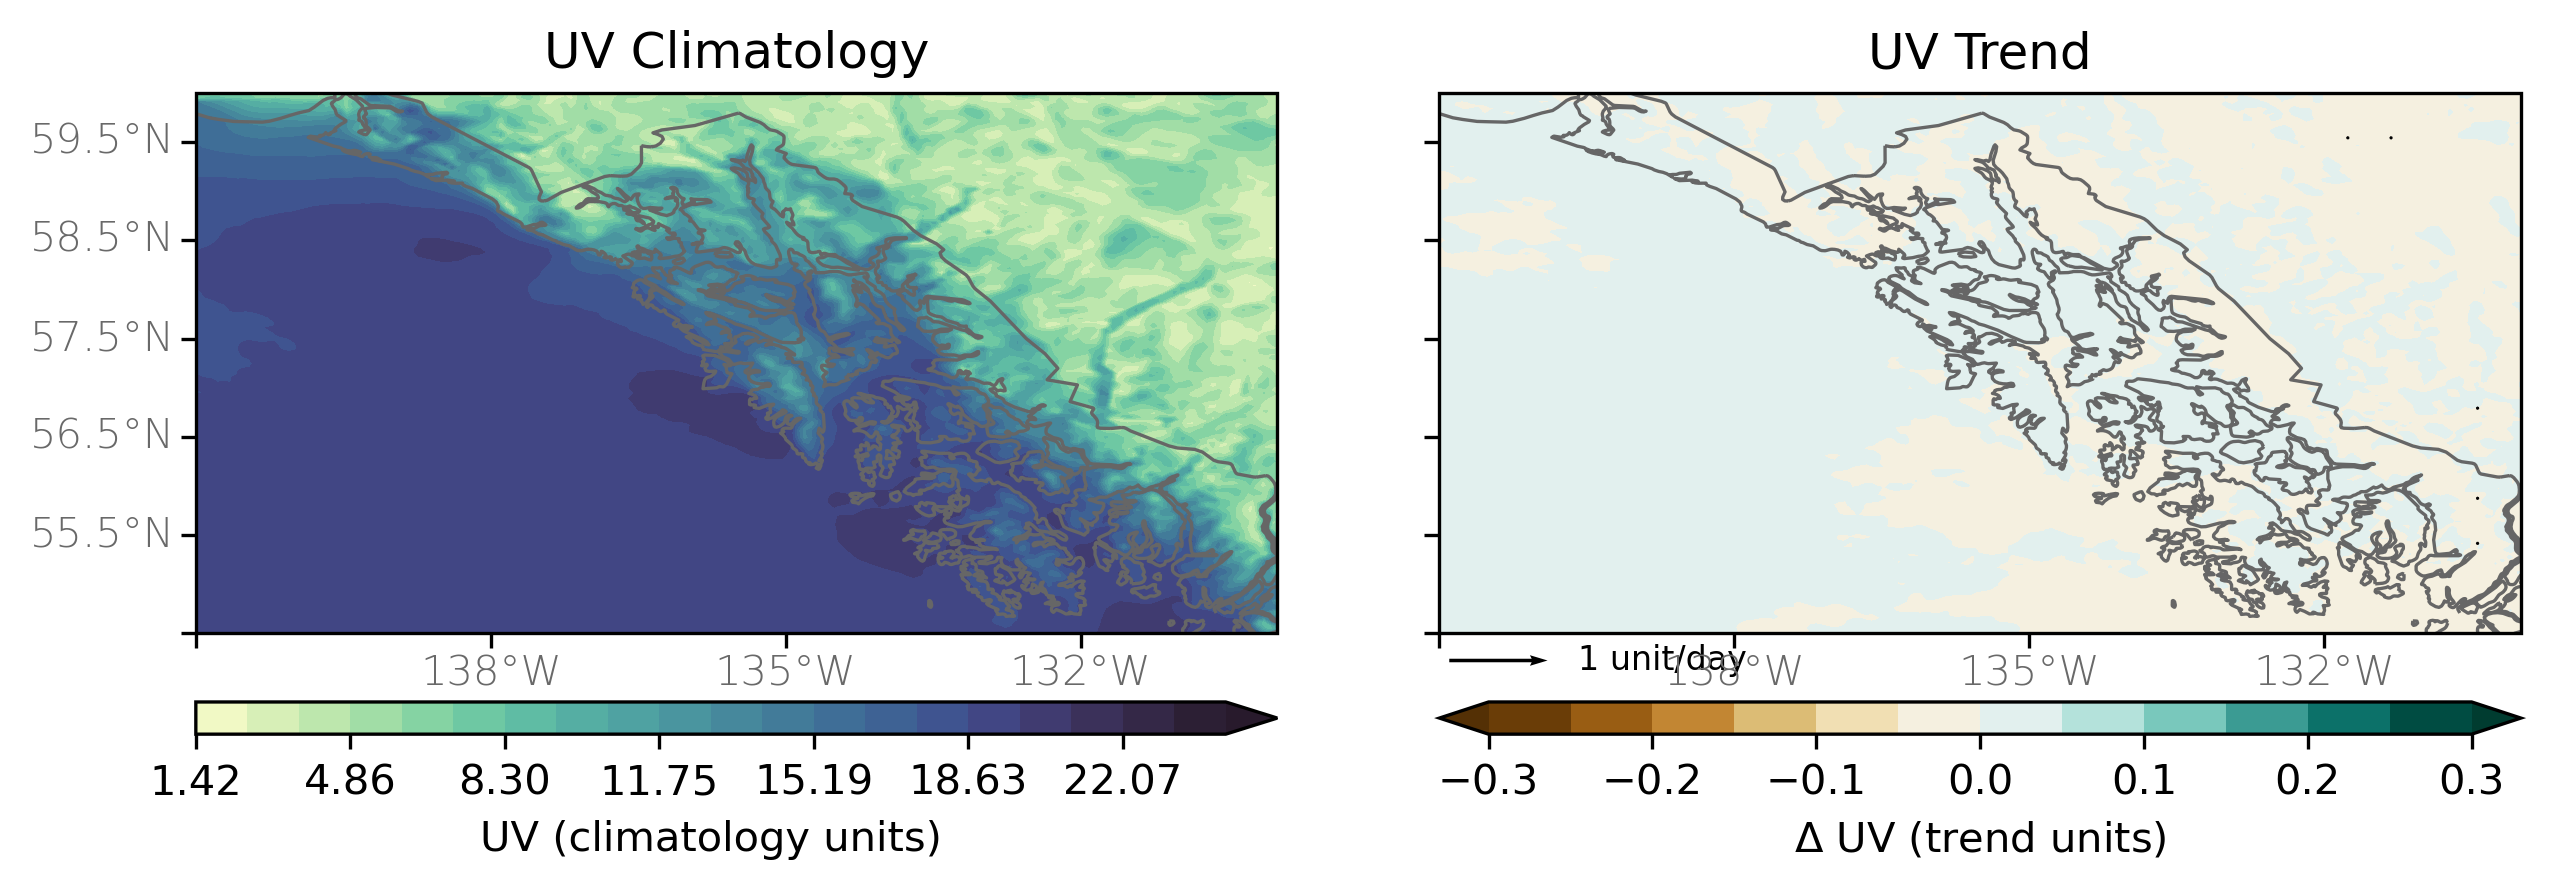

In [8]:




# Data for plotting
lons = ds.lon.values
lats = ds.lat.values

# fname = os.path.join(path_to_data, f"preprocessed/SEAK-WRF/{model}/trends/{varname}_{model}_trends.nc")
# ds = xr.open_dataset(fname)
varname = 'uv'
plot_trend_with_clim(trend, ds_clim, varname, lons, lats, model,
                         lonmin=-141., lonmax=-130., latmin=54.5, latmax=60.,
                         sig_level=0.1)